> Author Antoine CAILLON

In [ ]:
#@title Importing libraries...
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

from google.colab import files
import pickle as pk

from torch.utils.data import DataLoader

from torchvision.transforms import transforms
from torchvision.datasets import MNIST

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [ ]:
#@title Loading dataset
trainset = MNIST(root='./dataMNIST/',
                 train=True,
                 transform=transforms.ToTensor(),
                 download=True)
testset = MNIST(root='./dataMNIST/',
                train=False,
                transform=transforms.ToTensor(),
                download=True)
labels = ['#0','#1','#2','#3','#4','#5','#6','#7','#8','#9']

N_train = len(trainset)
N_test = len(testset)

batch=128

train_loader = DataLoader(dataset=trainset,
                          batch_size=batch,
                          shuffle=True)

test_loader = DataLoader(dataset=testset,
                         batch_size=batch,
                         shuffle=False)

In [ ]:
#@title Establishing architecture
class AE(nn.Module):
  def __init__(self):
    super(AE,self).__init__()
    
    self.act   = nn.ReLU()
    self.tanh  = nn.Tanh()
    
    self.enc1  = nn.Conv2d(1,16,5,padding=2,stride=2)
    self.enc1s = nn.Sequential(nn.BatchNorm2d(16),\
                               self.act)
    
    self.enc2  = nn.Conv2d(16,128,5,padding=2,stride=2)
    self.enc2s = nn.Sequential(nn.BatchNorm2d(128),\
                               self.act)
    
    self.enc3  = nn.Linear(7*7*128,1024)
    self.enc3s = nn.Sequential(nn.BatchNorm1d(1024),\
                               self.act)
    
    self.enc4  = nn.Linear(1024,128)
    self.enc4s = nn.Sequential(nn.BatchNorm1d(128),\
                               self.act)
    
    self.logvar = nn.Linear(128,32)
    
    self.mu    = nn.Linear(128,32)
    
    self.dec1  = nn.Linear(32,128)
    self.dec1s = nn.Sequential(nn.BatchNorm1d(128),\
                               self.act)
    
    self.dec2  = nn.Linear(128,1024)
    self.dec2s = nn.Sequential(nn.BatchNorm1d(1024),\
                               self.act)
    
    self.dec3  = nn.Linear(1024,7*7*128)
    self.dec3s = nn.Sequential(nn.BatchNorm1d(7*7*128),\
                               self.act)
    
    self.dec4  = nn.ConvTranspose2d(128,16,5,stride=2,padding=2)
    self.dec4s = nn.Sequential(nn.BatchNorm2d(16),\
                               self.act)
    
    self.dec5  = nn.ConvTranspose2d(16,1,5,stride=2,padding=2)
    self.dec5s = nn.Sequential(nn.BatchNorm2d(1),\
                               self.act)
    
    self.dec6  = nn.ConvTranspose2d(1,1,4,stride=1,padding=0)
    self.dec6s = nn.Sequential(nn.BatchNorm2d(1),\
                               nn.Sigmoid())
    
    nn.init.xavier_normal_(self.enc1.weight.data)
    nn.init.xavier_normal_(self.enc2.weight.data)
    nn.init.xavier_normal_(self.enc3.weight.data)
    nn.init.xavier_normal_(self.enc4.weight.data)
    nn.init.xavier_normal_(self.logvar.weight.data)
    nn.init.xavier_normal_(self.mu.weight.data)
    nn.init.xavier_normal_(self.dec1.weight.data)
    nn.init.xavier_normal_(self.dec2.weight.data)
    nn.init.xavier_normal_(self.dec3.weight.data)
    nn.init.xavier_normal_(self.dec4.weight.data)
    nn.init.xavier_normal_(self.dec5.weight.data)
    nn.init.xavier_normal_(self.dec6.weight.data)

    
  def encode(self,x):
    x = x.unsqueeze(1)
    #ENCODE
    x = self.enc1s(self.enc1(x))
    x = self.enc2s(self.enc2(x))
    x = x.view(-1,self.num_flat_features(x))
    x = self.enc3s(self.enc3(x))
    x = self.enc4s(self.enc4(x))
    
    logvar = self.logvar(x)
    mu     = self.mu(x)
    
    return logvar,mu
  
  def sample(self,logvar,mu):
    return mu + torch.randn_like(mu)*torch.exp(.5*logvar)
  
  def decode(self,x):
    #DECODE
    x = self.dec1s(self.dec1(x))
    x = self.dec2s(self.dec2(x))
    x = self.dec3s(self.dec3(x))
    x = x.view(-1,128,7,7)
    x = self.dec4s(self.dec4(x))
    x = self.dec5s(self.dec5(x))
    x = self.dec6s(self.dec6(x))
    return x
  
  def forward(self,x):
    logvar,mu = self.encode(x)
    z         = self.sample(logvar,mu)
    y         = self.decode(z)
    return y
  
  def num_flat_features(self,x):
    size = x.size()[1:]
    num  = 1
    for s in size:
      num *= s
    return num
  
model     = AE()
model     = model.to(device)

In [ ]:
#@title Training model...
n_ep = 100
train_loss_log = np.zeros(n_ep)
test_loss_log  = np.zeros(n_ep)


lr = 1e-1
optimizer = optim.Adam(model.parameters(),lr=lr)
for epoch in range(n_ep):

  model.train()
  
  for batch_idx, minibatch in enumerate(train_loader):
    minibatch = minibatch[0].to(device).squeeze(1)
    
    optimizer.zero_grad()
    
    logvar,mu = model.encode(minibatch)
    z         = model.sample(logvar,mu)
    output    = model.decode(z)
    
    rec_loss = F.binary_cross_entropy(output,minibatch.unsqueeze(1),\
                                     reduction="sum")
    
    kl_loss  = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1. - logvar)
    
    loss     = rec_loss + kl_loss
      
    train_loss_log[epoch] += loss.item()
    loss.backward()
    optimizer.step()
    
  model.eval()
  with torch.no_grad():
    for batch_idx,minibatch in enumerate(test_loader):
      minibatch = minibatch[0].to(device).squeeze(1)
      
      logvar,mu = model.encode(minibatch)
      z      = model.sample(logvar,mu)
      output = model.decode(z)
      
      rec_loss = F.binary_cross_entropy(output,minibatch.unsqueeze(1),\
                                       reduction="sum")
    
      kl_loss  = 0.25 * torch.sum(torch.exp(logvar) + mu**2 - 1. - logvar)
    
      loss     = rec_loss + kl_loss
      
      test_loss_log[epoch] += loss.item()
   
  if (epoch)%20==0:
    print("EPOCH #{} DONE, TRAIN_ERROR {}, TEST_ERROR {}".format(epoch,\
                                        train_loss_log[epoch],\
                                        test_loss_log[epoch]))
    lr /= 5.
    optimizer = optim.Adam(model.parameters(),lr=lr)
    

EPOCH #0 DONE, TRAIN_ERROR 9506560.595703125, TEST_ERROR 1318570.1638183594


KeyboardInterrupt: ignored

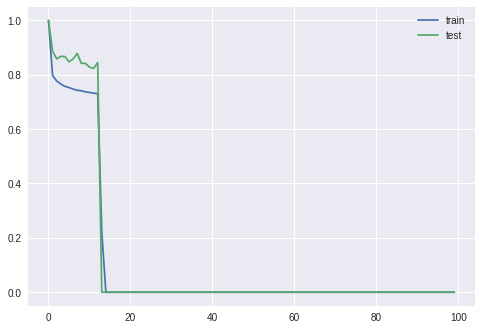

In [ ]:
#@title Plotting error log
plt.plot(train_loss_log/max(train_loss_log))
plt.plot(test_loss_log/max(test_loss_log))
plt.legend(["train","test"])
plt.show()

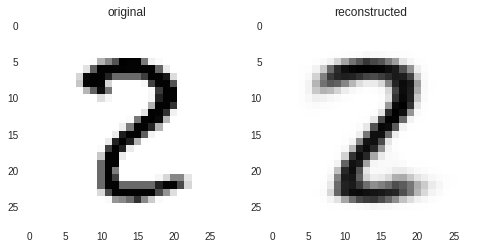

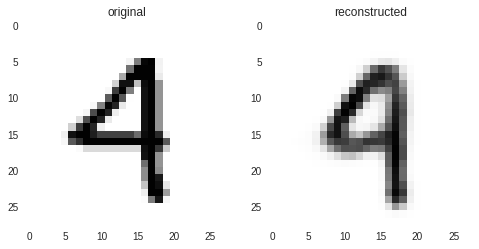

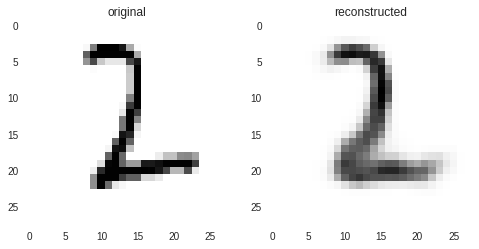

In [ ]:
#@title Reconstruction test
model.eval()
for i in range(3):
  with torch.no_grad():
    inp = testset[np.random.randint(0,1000)][0].to(device)
    out = model(inp).squeeze(0).squeeze(0)
    plt.subplot(121)
    plt.imshow(inp.squeeze(0).squeeze(0).cpu().numpy(),interpolation="none")
    plt.grid()
    plt.title("original")
    plt.subplot(122)
    plt.imshow(out.cpu().numpy(),interpolation="none")
    plt.grid()
    plt.title("reconstructed")
    plt.show()

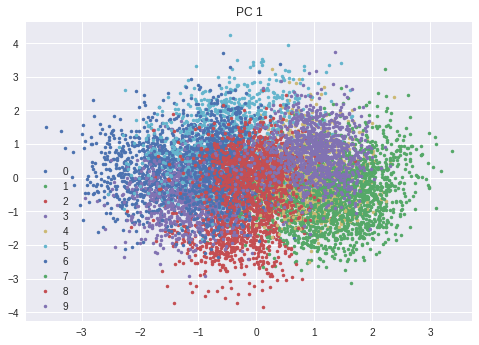

In [ ]:
#@title Displaying 2D PCA latent space
def load_test_set(n):
  y = torch.cat([testset[i][0] for i in range(n)],0)
  z = [testset[i][1] for i in range(n)]
  return y,z

n = 10000

with torch.no_grad():
  x,label   = load_test_set(n)
  logvar,mu = model.encode(x.to(device))
  z         = model.sample(logvar,mu).cpu().numpy()

Rxx = np.cov(z.T)
[U,S,V] = np.linalg.svd(Rxx,full_matrices=True)
W = U[:,:2]

latent = z.dot(W)

sort = np.argsort(label)
label = np.asarray(label)[sort]
latent = latent[sort,:]

for i in range(10):
  plt.plot(latent[label==i,0],latent[label==i,1],"C{}.".format(i))
plt.legend(range(10))
plt.title("PC 1")
plt.show()

#for i in range(10):
#  plt.plot(latent[label==i,2],latent[label==i,3],"C{}.".format(i))  

#plt.legend(range(10))
#plt.title("PC 2")
#plt.show()

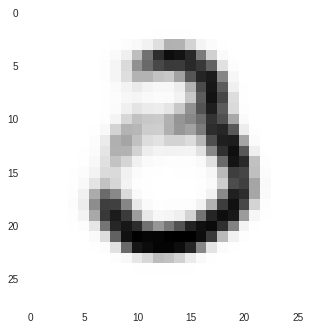

In [ ]:
#@title Reconstruction from the 2D latent space
with torch.no_grad():
  test = torch.tensor(np.asarray([-2,-1.5]).dot(W.T),dtype=torch.float).to(device)
  #test = torch.tensor(latent[3,:].dot(W.T),dtype=torch.float).to(device)
  img  = model.decode(test.unsqueeze(0)).squeeze(0).squeeze(0)
  plt.imshow(img.cpu().numpy())
  plt.grid()
  plt.show()